# A Tour of Digital Audio in Python/Numpy
### <a href = "https://www.ctralie.com">Chris Tralie</a> 

## Bio

### Upper Dublin Computer Club President 2005-2007

<img src = "Pics/acsl2007.jpg" width="50%">

### Graduated Upper Dublin 2007

<img src = "Pics/udgrad.jpg" width="50%">

### Princeton Class of 2011, Major in Electrical Engineering + Computer Science

<img src = "Pics/princeton.jpg" width="20%">

### Duke University Ph.D. in Electrical And Computer Engineering, 2017

<img src = "Pics/duke.jpg" width="50%">

### Assistant Professor in Math/CS At Ursinus College Since Fall 2019

<img src = "Pics/seraiah3.jpg" width="50%">

# Digital Audio: The Basics

I'll be giving some highlights of a course I'm currently teaching to Ursinus undergraduates.  Course web site at <a href = "https://ursinus-cs372-s2023.github.io/CoursePage/">this link</a>


In [1]:
import numpy as np
import matplotlib.pyplot as plt

def blackman_harris_window(N):
    """
    Create a Blackman-Harris Window
    
    Parameters
    ----------
    N: int
        Length of window
    
    Returns
    -------
    ndarray(N): Samples of the window
    """
    a0 = 0.35875
    a1 = 0.48829
    a2 = 0.14128
    a3 = 0.01168
    t = np.arange(N)/N
    return a0 - a1*np.cos(2*np.pi*t) + a2*np.cos(4*np.pi*t) - a3*np.cos(6*np.pi*t)

def stft(x, w, h, win_fn=blackman_harris_window):
    """
    Compute the complex Short-Time Fourier Transform (STFT)
    Parameters
    ----------
    x: ndarray(N)
        Full audio clip of N samples
    w: int
        Window length
    h: int
        Hop length
    win_fn: int -> ndarray(N)
        Window function
    
    Returns
    -------
    ndarray(w, nwindows, dtype=np.complex) STFT
    """
    N = len(x)
    nwin = int(np.ceil((N-w)/h))+1
    # Make a 2D array
    # The rows correspond to frequency bins
    # The columns correspond to windows moved forward in time
    S = np.zeros((w, nwin), dtype=np.complex)
    # Loop through all of the windows, and put the fourier
    # transform amplitudes of each window in its own column
    for j in range(nwin):
        # Pull out the audio in the jth window
        xj = x[h*j:h*j+w]
        # Zeropad if necessary
        if len(xj) < w:
            xj = np.concatenate((xj, np.zeros(w-len(xj))))
        # Apply window function
        xj = win_fn(w)*xj
        # Put the fourier transform into S
        S[:, j] = np.fft.fft(xj)
    return S

def amplitude_to_db(S, amin=1e-10, ref=1):
    """
    Convert an amplitude spectrogram to be expressed in decibels
    
    Parameters
    ----------
    S: ndarray(win, T)
        Amplitude spectrogram
    amin: float
        Minimum accepted value for the spectrogram
    ref: int
        0dB reference amplitude
        
    Returns
    -------
    ndarray(win, T)
        The dB spectrogram
    """
    SLog = 20.0*np.log10(np.maximum(amin, S))
    SLog -= 20.0*np.log10(np.maximum(amin, ref))
    return SLog

def istft(S, w, h):
    """
    Compute the complex inverse Short-Time Fourier Transform (STFT)
    Parameters
    ----------
    S: ndarray(w, nwindows, dtype=np.complex)
        Complex spectrogram
    w: int
        Window length
    h: int
        Hop length
    
    Returns
    -------
    y: ndarray(N)
        Audio samples of the inverted STFT
    """
    N = (S.shape[1]-1)*h + w # Number of samples in result
    y = np.zeros(N)
    for j in range(S.shape[1]):
        xj = np.fft.ifft(S[:, j])
        y[j*h:j*h+w] += np.real(xj)
    y /= (w/h/2)
    return y


def plot_fourier_mag(x, fs):
    """
    Given audio samples and the sample rate, plot
    the magnitude of the Fourier transform of x with 
    the appropriate frequency labels
    Parameters
    ----------
    x: ndarray(N)
        The audio samples
    fs: int
        The sample rate in hz
    """
    xft = np.abs(np.fft.fft(x))
    freqs = np.fft.fftfreq(len(x), 1/fs)
    plt.plot(freqs[freqs > 0], xft[freqs > 0])
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude")
    return xft

def plot_stft(S, sr, hop):
    """
    Plot the spectrogram associated to a short-time
    Fourier Transform, using a log scale

    Parameters
    ----------
    S: ndarray(win, n_frames, dtype=complex):
        Short-time fourier transform
    sr: int
        Sample rate
    hop: int
        Hop length between frames
    """
    win = S.shape[0]
    S = amplitude_to_db(np.abs(S))
    plt.imshow(S, extent=(0, S.shape[1]*hop/sr, 0, sr), aspect='auto', cmap='magma')
    plt.xlabel("Time (Sec)")
    plt.ylabel("Frequency (hz)")

In [3]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import IPython.display as ipd
from dsp import *

First, what is audio?  Let's load some in and find out!

In [5]:
!wget "https://ctralieteaching.s3.amazonaws.com/UDHS/femalecountdown.wav"

--2023-03-28 14:41:37--  https://ctralieteaching.s3.amazonaws.com/UDHS/femalecountdown.wav
Resolving ctralieteaching.s3.amazonaws.com (ctralieteaching.s3.amazonaws.com)... 52.217.172.241, 52.217.199.73, 52.217.205.65, ...
Connecting to ctralieteaching.s3.amazonaws.com (ctralieteaching.s3.amazonaws.com)|52.217.172.241|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1083854 (1.0M) [audio/wav]
Saving to: ‘femalecountdown.wav’

femalecountdown.wav 100%[===================>]   1.03M  5.27MB/s    in 0.2s    

2023-03-28 14:41:37 (5.27 MB/s) - ‘femalecountdown.wav’ saved [1083854/1083854]



<IPython.core.display.Javascript object>


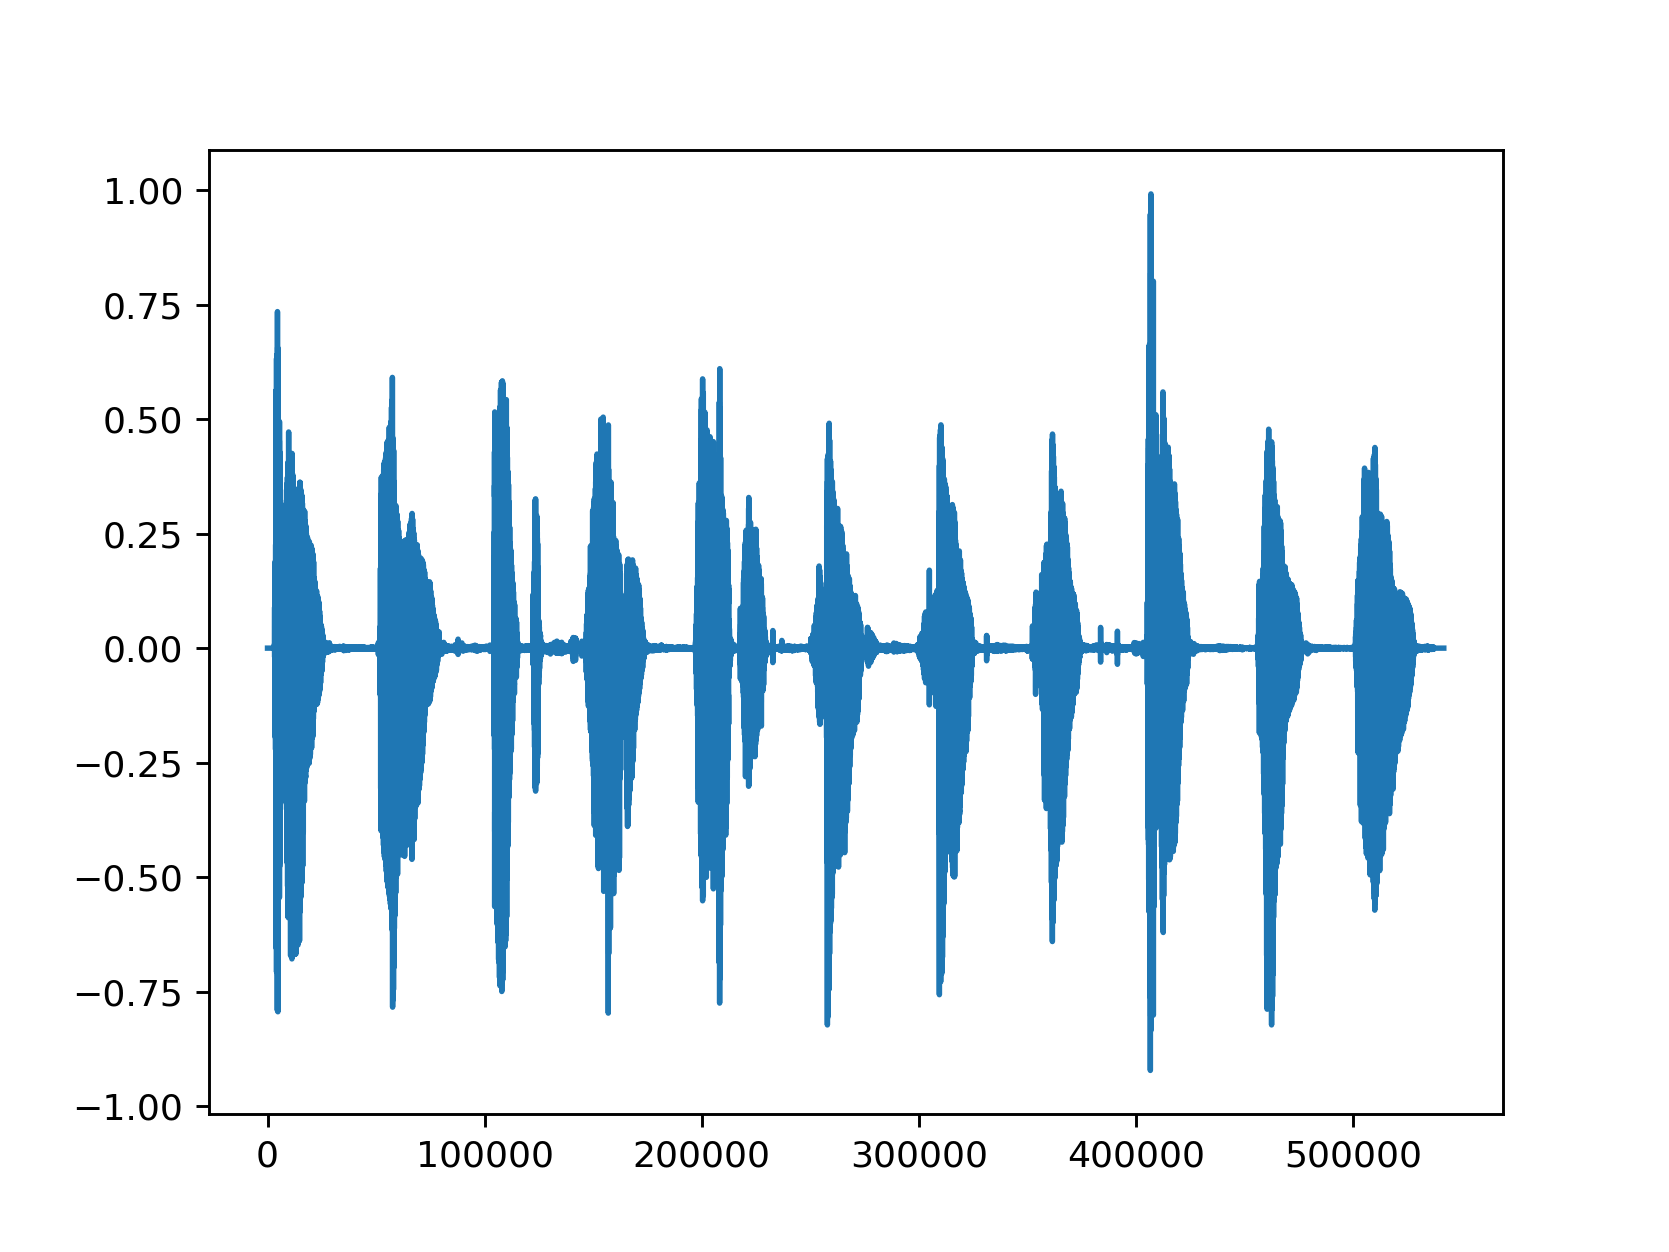

In [6]:
sr, x = wavfile.read("femalecountdown.wav")
x = x/32768
plt.figure()
plt.plot(x)
ipd.Audio(x, rate=sr)

In [ ]:
# Show sample rate

In [ ]:
# Show slicing

In [ ]:
# Show reversing

### <a href = "https://ursinus-cs372-s2023.github.io/CoursePage/ClassExercises/Week1/Week1_AudioReverseGame/">Audio reversing game</a>

In [ ]:
# Show noise

## Filtering Audio

In [ ]:
# Windowed energy
def get_energy(x, win):
    """
    Compute the energy in a window around each sample
    
    Parameters
    ----------
    x: ndarray(N)
        Audio samples
    win: int
        Window length in which to sum energy
    
    Returns
    -------
    ndarray(N): Energy arond each sample
    """
    eng = x**2
    w = np.zeros(win//2)
    eng = np.concatenate((w, eng, w))
    eng = np.cumsum(eng)
    return eng[win::] - eng[0:-win]


sr, x = wavfile.read("Audio/femalecountdown.wav")
x = x/32768
eng = get_energy(x, 1000)

plt.figure()
plt.subplot(211)
plt.plot(x)
plt.ylabel("Audio Waveform")
plt.subplot(212)
plt.plot(eng)
plt.xlabel("Sample Index")
plt.ylabel("Energy")
plt.tight_layout()

In [ ]:
# Filter by energy

In [ ]:
# Windowed zero crossings
def get_zcs(x, win):
    """
    Compute the zero crossings in a window around each sample
    
    Parameters
    ----------
    x: ndarray(N)
        Audio samples
    win: int
        Window length in which to sum energy
    
    Returns
    -------
    ndarray(N): Zero crossing count arond each sample
    """
    zcs = np.sign(x[1::]) - np.sign(x[0:-1]) == 2
    w = np.zeros(win//2)
    zcs = np.concatenate((w, [0], zcs, w))
    zcs = np.cumsum(zcs)
    return zcs[win::] - zcs[0:-win]

sr, x = wavfile.read("Audio/femalecountdown.wav")
x = x/32768
zcs = get_zcs(x, 4000)

plt.figure()
plt.subplot(211)
plt.plot(x)
plt.ylabel("Audio Waveform")
plt.subplot(212)
plt.plot(eng)
plt.xlabel("Sample Index")
plt.ylabel("Zero Crossings")
plt.tight_layout()

In [ ]:
# Filter by zero crossings


## Periodic Sounds/Pitches

Define period, define frequency, and show cosine

In [ ]:
# Show cosine sampled at a particular period

# What do we notice when the frequency goes up?

Equation for pitch perception

In [ ]:
# Make happy birthday tune with cosines

In [ ]:
# Make happy birthday tune with square waves

# Convolution / Echoes

<img src = "Convolution.gif">

In [ ]:
sr, x = wavfile.read("Audio/jessiesgirl.wav")
x = x/32768
ipd.Audio(x, rate=sr)

In [ ]:
# Show example with JFK Tunnel / Jessie's Girl
sr, h = wavfile.read("Audio/jfktunnel.wav")
h = h/32768
ipd.Audio(h, rate=sr)

In [ ]:
from scipy.signal import fftconvolve

# Convolve x and h, compare result to x

### Comb Filter




In [ ]:
# Example on noise

In [ ]:
# Example on audio
sr, x = wavfile.read("Audio/robot.wav")
ipd.Audio(x, rate=sr)

# Spectrograms 


### <a href = "https://musiclab.chromeexperiments.com/spectrogram">Live spectrogram demo</a>


In [ ]:
sr, x = wavfile.read("Audio/violincastinets.wav")
x = x/32768
win = 2048
hop = 512
S = stft(x, win, hop)
plt.figure()
plot_stft(S, sr, hop)
plt.ylim([0, 8000])
ipd.Audio(x, rate=sr)

### Beepy Tunes, aka Hacking Shazam

In [ ]:
sr, x = wavfile.read("Audio/rr.wav")

In [ ]:
from scipy import ndimage

win = 2048
hop = 1024
time_win = 8
freq_win = 5
max_freq = 256

S = np.abs(stft(x, win, hop))
M = ndimage.maximum_filter(S, size=(freq_win*2+1, time_win*2+1)) == S
M = M[0:256, :]
I, J = np.meshgrid(np.arange(M.shape[0]), np.arange(M.shape[1]), indexing='ij')
I = I[M == 1]
J = J[M == 1]

plt.figure()
plt.imshow(amplitude_to_db(S)[0:max_freq, :], cmap='gray', aspect='auto')
plt.scatter(J, I, s=1, c='C1')
plt.ylim([0, max_freq])

In [ ]:
N = x.size
t = np.arange(win)/sr
y = np.zeros(N)
hann_win = 0.5*(1 - np.cos(2*np.pi*np.arange(win)/win))
for i, j in zip(I, J):
    freq = i*sr/win
    blip = np.cos(2*np.pi*freq*t)
    j1 = j*hop
    L = len(y[j1:j1+win])
    y[j1:j1+win] += (hann_win*blip)[0:L]

In [ ]:
ipd.Audio(y, rate=sr)

# FM Synthesis (Time Permitting)

More info at <a href = "https://ursinus-cs372-s2023.github.io/Modules/Module6/Video1">this link</a>

In [ ]:
sr = 44100
t = np.arange(sr*2)/sr
fc = 440
fm = 440
I = 4
y = np.cos(2*np.pi*fc*t + I*np.sin(2*np.pi*fm*t))
ipd.Audio(y, rate=sr)